# ISLR Chapter 8 - End of Chapter Applied exercises code portion solutions¶

Exercises from: "An Introduction to Statistical Learning with Applications in R" (Springer, 2013) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani

Data: http://faculty.marshall.usc.edu/gareth-james/ISL/data.html

Code Solutions by Arthur Avila

### 7. In the lab, we applied random forests to the `Boston` data using `mtry=6` and using `ntree=25` and `ntree=500`. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for `mtry` and `ntree`. You can model your plot after Figure 8.10. Describe the results obtained.

In [1]:
require(MASS)
require(randomForest)
require(tidyverse)
require(broom)

Loading required package: MASS
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()  masks randomForest::combine()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ ggplot2::margin() masks randomForest::margin()
✖ dplyr::select()   masks MASS::select()
Loading required package: broom


In [2]:
set.seed(1)
train = sample(1:nrow(Boston), nrow(Boston)/2)
y_test = Boston[-train,'medv']
# rf.boston=randomForest(medv~.,data=Boston,subset=train,mtry=6,importance=TRUE)
# yhat.rf = predict(rf.boston,newdata=Boston[-train,])
# mean((yhat.rf-boston.test)^2)
trees = data.frame(ntree = seq(10,250,10))
nvars = data.frame(mtry = 1:(ncol(Boston)-1))
params = merge(trees, nvars)

rfmse <- function(x){
    rf = randomForest(medv~., data=Boston, subset=train, mtry=x['mtry'], ntree=x['ntree'])
    y_pred = predict(rf,newdata=Boston[-train,])
    mse = mean((y_test-y_pred)**2)
    return(mse)
}

#require(parallel)
#cl = makeForkCluster(detectCores())
#params$mse = parApply(cl, params, 1, rfmse)
#stopCluster(cl)
params$mse = apply(params, 1, rfmse)

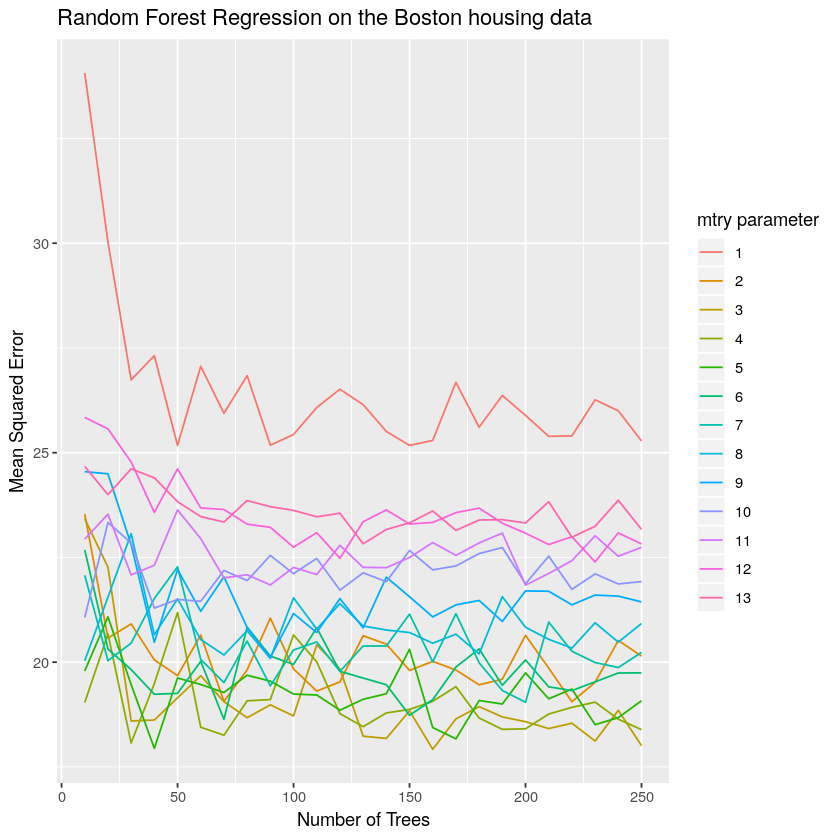

In [3]:
ggplot(params, aes(ntree, mse, col=as.factor(mtry))) + 
  geom_line() + 
  labs(x = 'Number of Trees',
       y = 'Mean Squared Error',
       title = 'Random Forest Regression on the Boston housing data') +
  scale_color_discrete(name='mtry parameter')
  

### 8. In the lab, a classification tree was applied to the `Carseats` data set after converting `Sales` into a qualitative response variable. Now we will seek to predict `Sales` using regression trees and related approaches, treating the response as a quantitative variable.

#### (a) Split the data set into a training set and a test set.

#### (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

#### (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

#### (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the `importance()` function to determine which variables are most important.

#### (e) Use random forests to analyze this data. What test MSE do you obtain? Use the `importance()` function to determine which variables are most important. Describe the effect of $m$, the number of variables considered at each split, on the error rate obtained.

Loading required package: ISLR
Loading required package: tree
Registered S3 method overwritten by 'tree':
  method     from
  print.tree cli 


MSE  4.922039

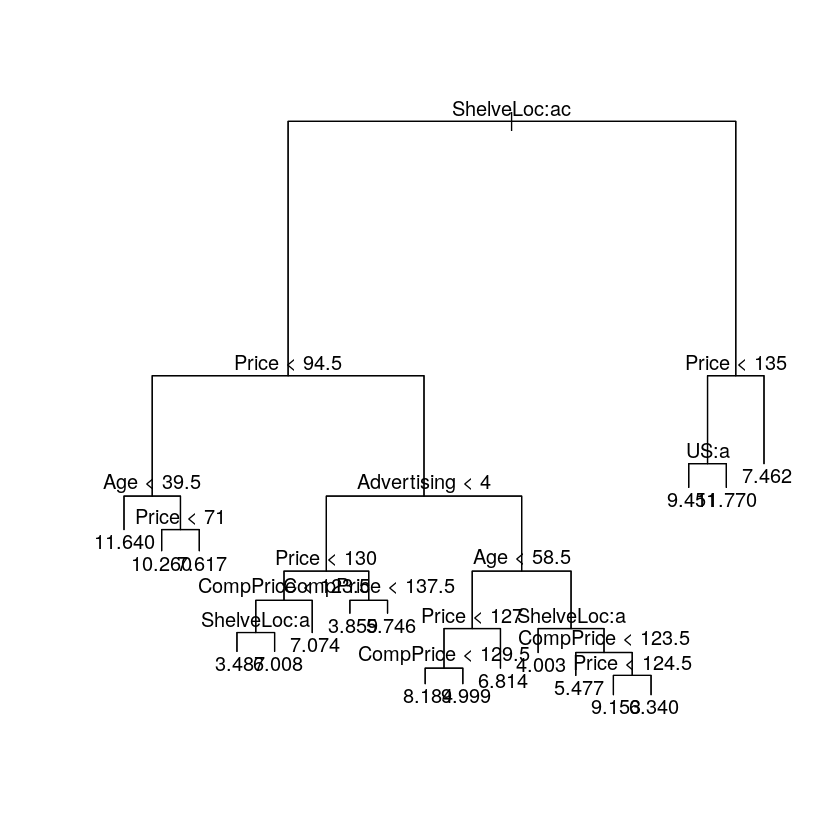

In [4]:
require(ISLR)
require(tree)

# a
set.seed(1)
train = sample(1:nrow(Carseats), nrow(Carseats)/2)
y_test = Carseats[-train,'Sales']

# b
car.tree = tree(Sales~., data=Carseats, subset=train)
y_pred = predict(car.tree, newdata = Carseats[-train,])
mse = mean((y_test-y_pred)**2)
cat('MSE ',mse)
plot(car.tree)
text(car.tree)


In [5]:
summary(car.tree)


Regression tree:
tree(formula = Sales ~ ., data = Carseats, subset = train)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Age"         "Advertising" "CompPrice"  
[6] "US"         
Number of terminal nodes:  18 
Residual mean deviance:  2.167 = 394.3 / 182 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-3.88200 -0.88200 -0.08712  0.00000  0.89590  4.09900 

MSE  5.318073

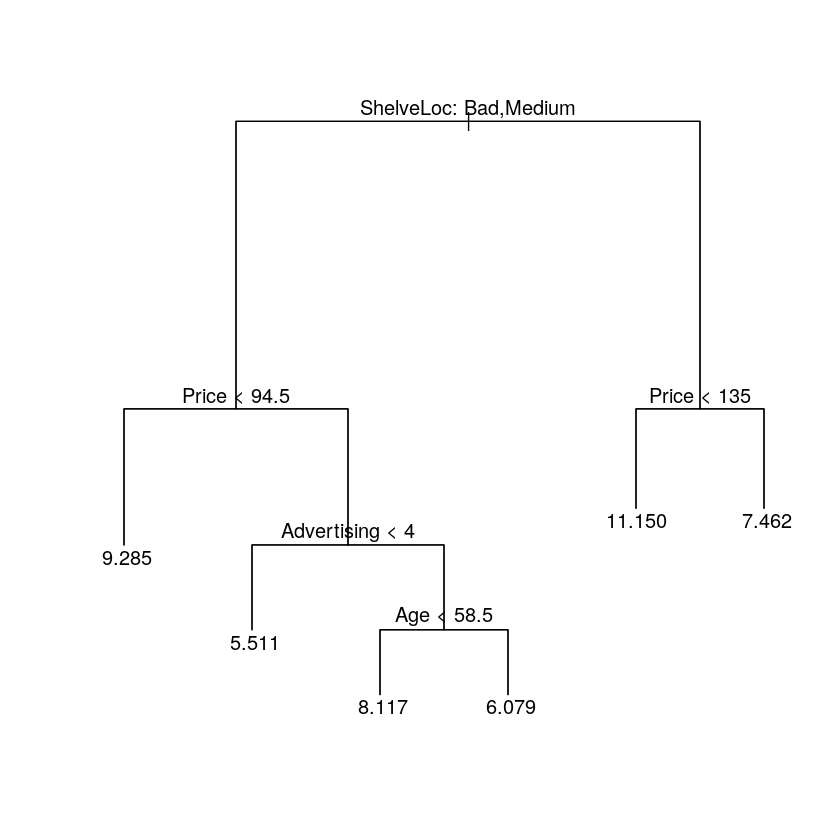

In [6]:
car.prune=prune.tree(car.tree,best=6)
plot(car.prune)
text(car.prune,pretty=0)
y_pred=predict(car.prune,newdata=Carseats[-train,])
mse = mean((y_test-y_pred)**2)
cat('MSE ',mse)


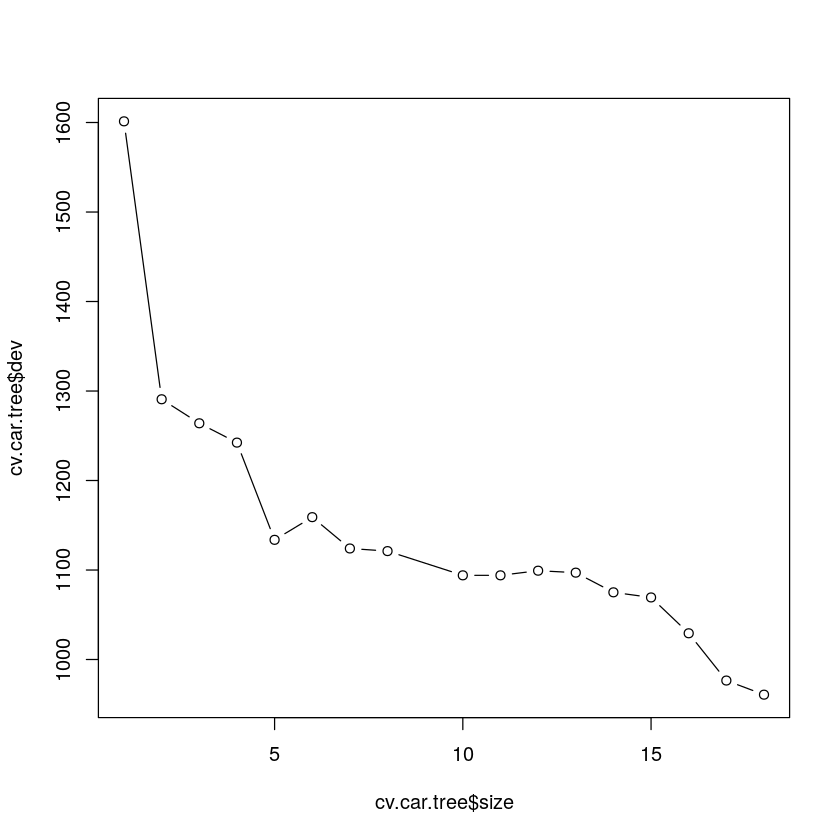

In [7]:
# c
set.seed(42)
cv.car.tree = cv.tree(car.tree)
plot(cv.car.tree$size,cv.car.tree$dev,type='b')


MSE  2.634036

,%IncMSE,IncNodePurity
CompPrice,24.3259891,173.476045
Income,6.6540279,89.748316
Advertising,14.3973094,99.814960
Population,-1.0643934,60.998526
Price,54.2820879,505.967167
ShelveLoc,48.3378084,365.763366
Age,16.2819944,158.470863
Education,0.5335722,42.370016
Urban,-1.2076729,9.756505
US,5.5866157,16.067594


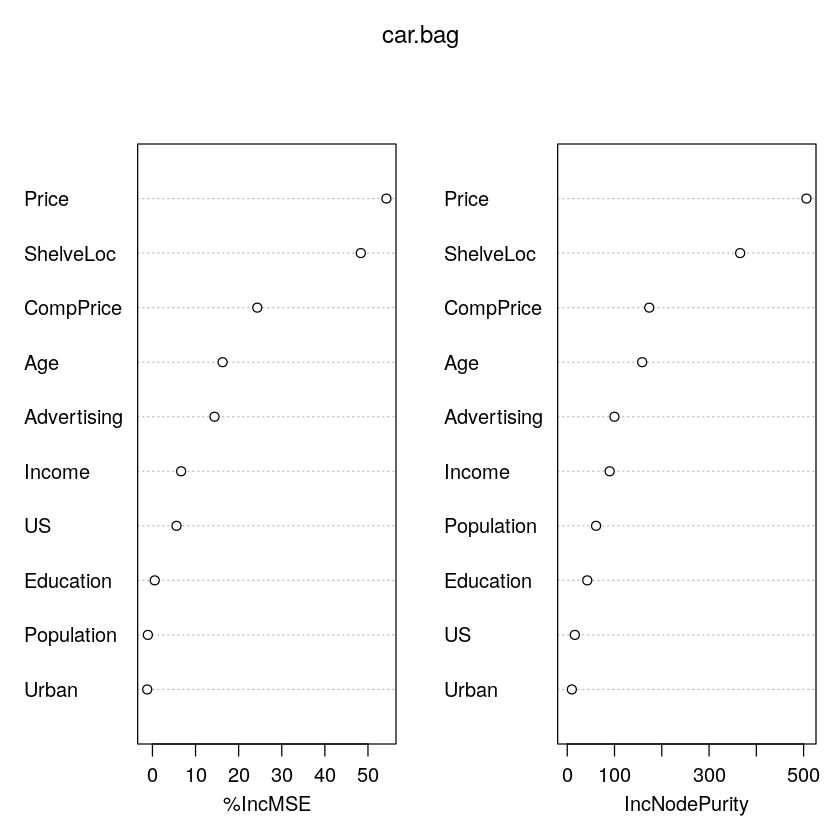

In [8]:
# d bagging
p = ncol(Carseats)-1

car.bag = randomForest(Sales~., data=Carseats, subset=train, mtry=p, importance=T)
y_pred=predict(car.bag,newdata=Carseats[-train,])
mse = mean((y_test-y_pred)**2)
cat('MSE ',mse)
par(mfrow=c(1,2))
importance(car.bag)
varImpPlot(car.bag)

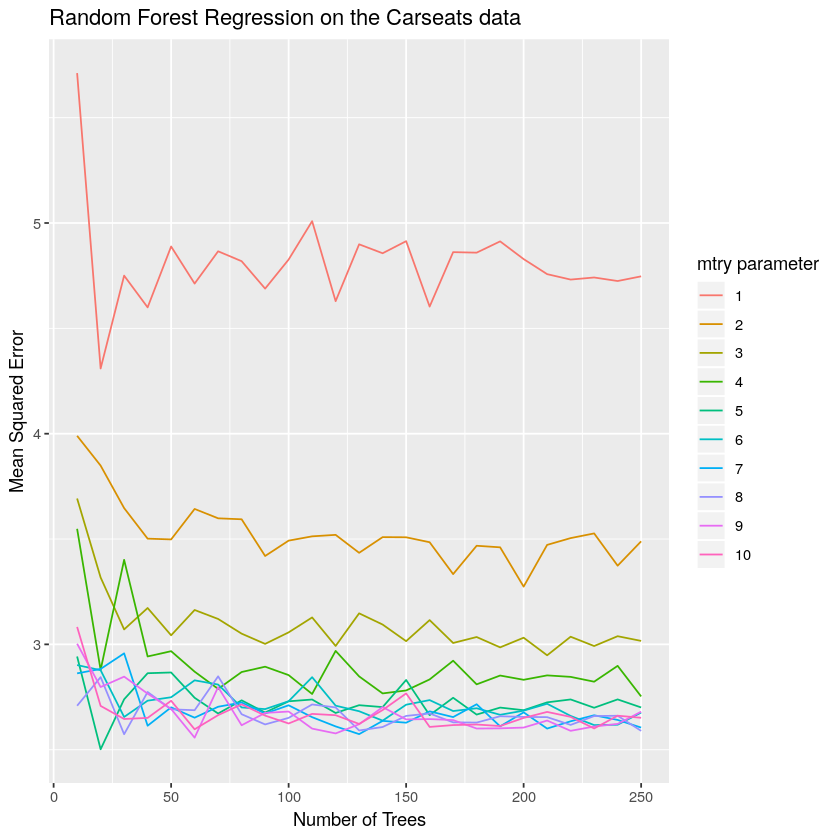

In [9]:
trees = data.frame(ntree = seq(10,250,10))
nvars = data.frame(mtry = 1:p)
params = merge(trees, nvars)

rfmse <- function(x){
    rf = randomForest(Sales~., data=Carseats, subset=train, mtry=x['mtry'], ntree=x['ntree'])
    y_pred = predict(rf,newdata=Carseats[-train,])
    mse = mean((y_test-y_pred)**2)
    return(mse)
}

params$mse = apply(params, 1, rfmse)

ggplot(params, aes(ntree, mse, col=as.factor(mtry))) + 
  geom_line() + 
  labs(x = 'Number of Trees',
       y = 'Mean Squared Error',
       title = 'Random Forest Regression on the Carseats data') +
  scale_color_discrete(name='mtry parameter')

### 9. This problem involves the OJ data set which is part of the ISLR package.

#### (a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [10]:
set.seed(786787)
train = sample(1:nrow(OJ), 800)
y_test = OJ[-train,'Purchase']

#### (b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. Use the summary() function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?

In [11]:
oj.tree = tree(Purchase~., data=OJ, subset=train)
summary(oj.tree)


Classification tree:
tree(formula = Purchase ~ ., data = OJ, subset = train)
Variables actually used in tree construction:
[1] "LoyalCH"       "SalePriceMM"   "ListPriceDiff" "PriceCH"      
Number of terminal nodes:  8 
Residual mean deviance:  0.7296 = 577.8 / 792 
Misclassification error rate: 0.1625 = 130 / 800 

#### (c) Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.

In [12]:
oj.tree

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 800 1061.00 CH ( 0.62250 0.37750 )  
   2) LoyalCH < 0.5036 345  409.90 MM ( 0.28116 0.71884 )  
     4) LoyalCH < 0.035047 54    0.00 MM ( 0.00000 1.00000 ) *
     5) LoyalCH > 0.035047 291  370.50 MM ( 0.33333 0.66667 )  
      10) SalePriceMM < 2.04 156  161.00 MM ( 0.21154 0.78846 ) *
      11) SalePriceMM > 2.04 135  186.80 MM ( 0.47407 0.52593 )  
        22) LoyalCH < 0.277189 50   57.31 MM ( 0.26000 0.74000 ) *
        23) LoyalCH > 0.277189 85  114.40 CH ( 0.60000 0.40000 ) *
   3) LoyalCH > 0.5036 455  331.50 CH ( 0.88132 0.11868 )  
     6) LoyalCH < 0.753545 181  200.80 CH ( 0.75691 0.24309 )  
      12) ListPriceDiff < 0.18 50   68.99 MM ( 0.46000 0.54000 ) *
      13) ListPriceDiff > 0.18 131  101.10 CH ( 0.87023 0.12977 ) *
     7) LoyalCH > 0.753545 274   85.84 CH ( 0.96350 0.03650 )  
      14) PriceCH < 1.975 190   22.19 CH ( 0.98947 0.01053 ) *
      15) PriceCH > 1.975 84   52.83 CH ( 0

#### (d) Create a plot of the tree, and interpret the results.

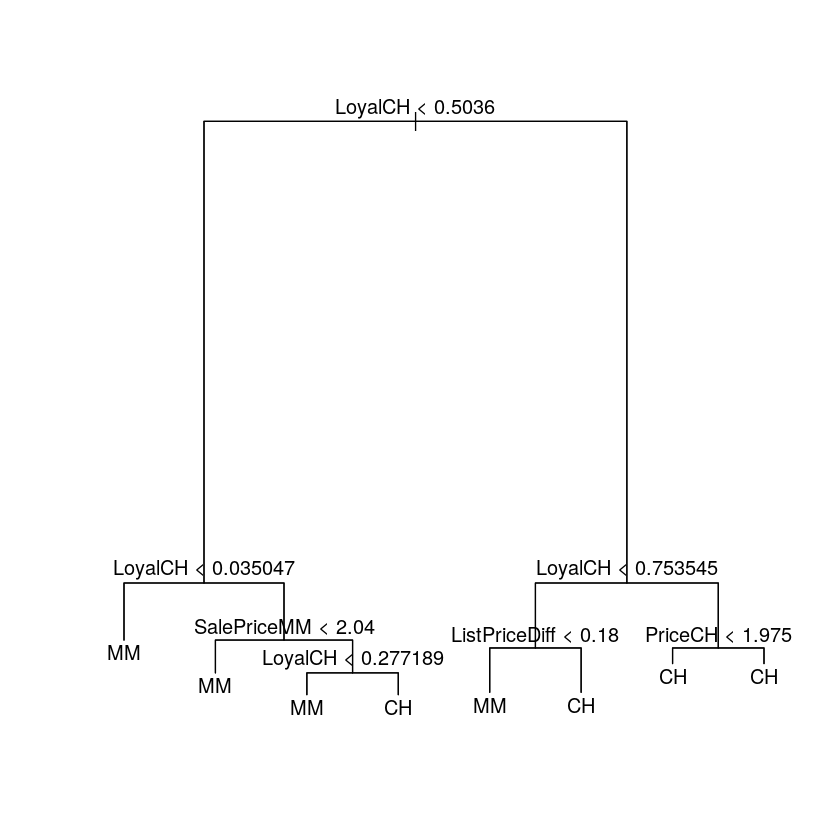

In [13]:
plot(oj.tree)
text(oj.tree)

#### (e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [14]:
y_pred = predict(oj.tree, newdata=OJ[-train,], type='class')
class_table = table(y_test, y_pred)
Accuracy = sum(y_pred == y_test)/length(y_test)
class_table
cat('Accuracy: ', Accuracy)

      y_pred
y_test  CH  MM
    CH 132  23
    MM  31  84

Accuracy:  0.8

#### (f) Apply the cv.tree() function to the training set in order to determine the optimal tree size.

#### (g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.

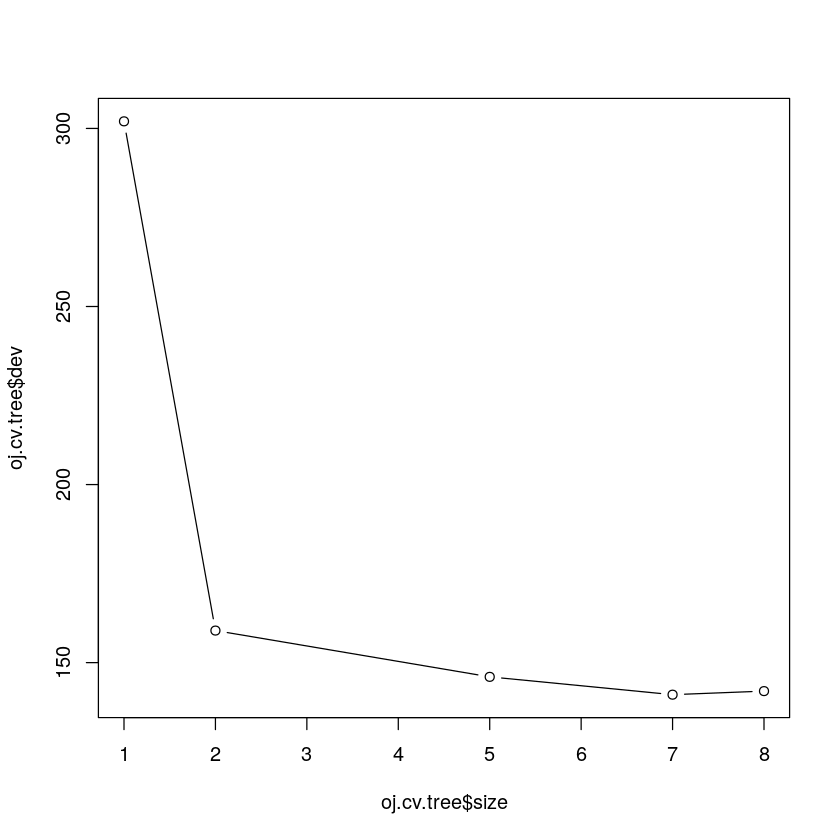

In [15]:
set.seed(3)
oj.cv.tree = cv.tree(oj.tree, FUN=prune.misclass)
plot(oj.cv.tree$size, oj.cv.tree$dev, 'b')

#### (h) Which tree size corresponds to the lowest cross-validated classification error rate?

In [16]:
oj.cv.tree

best_size = oj.cv.tree$size[which.min(oj.cv.tree$dev)]
best_size

$size
[1] 8 7 5 2 1

$dev
[1] 142 141 146 159 302

$k
[1]       -Inf   0.000000   2.000000   5.666667 151.000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

[1] 7

#### (i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

In [17]:
oj.pruned = prune.tree(oj.tree, best=best_size)

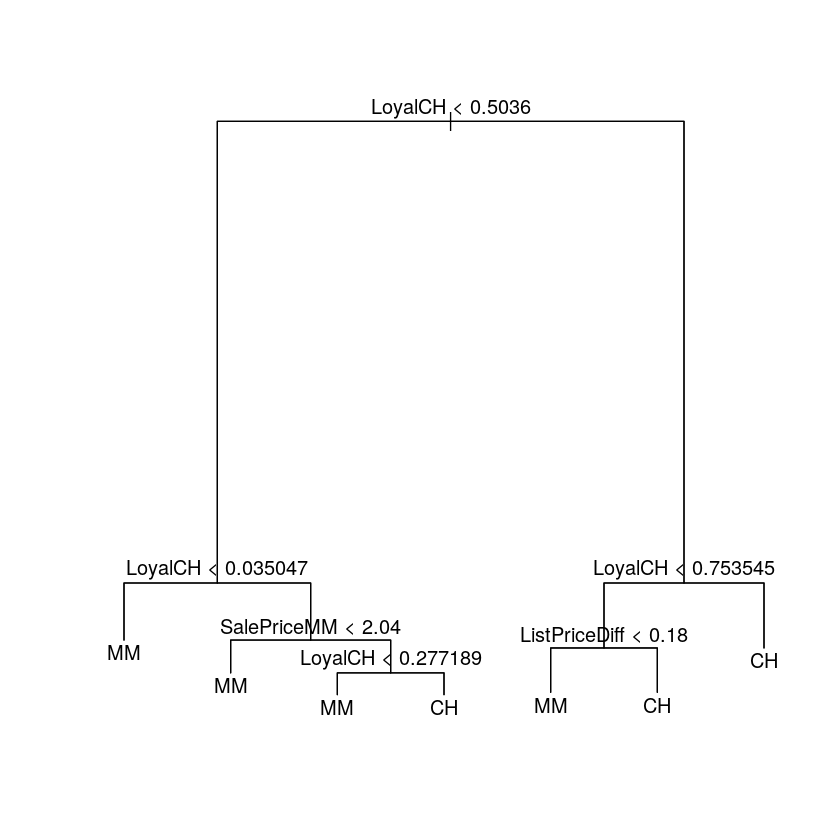

In [18]:
plot(oj.pruned)
text(oj.pruned)

#### (j) Compare the training error rates between the pruned and unpruned trees. Which is higher?

In [19]:
y_train = OJ[train,'Purchase']
y_hat_unpruned =  predict(oj.tree, type='class')
y_hat_pruned = predict(oj.pruned, type='class')

unpruned_table = table(y_train, y_hat_unpruned)
Accuracy_unpruned = sum(y_hat_unpruned == y_train)/length(y_train)
unpruned_table
cat('Unpruned Accuracy: ', Accuracy_unpruned)

pruned_table = table(y_train, y_hat_pruned)
Accuracy_pruned = sum(y_hat_pruned == y_train)/length(y_train)
pruned_table
cat('Pruned Accuracy: ', Accuracy_pruned)

       y_hat_unpruned
y_train  CH  MM
     CH 429  69
     MM  61 241

Unpruned Accuracy:  0.8375

       y_hat_pruned
y_train  CH  MM
     CH 429  69
     MM  61 241

Pruned Accuracy:  0.8375

#### (k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [20]:
y_pred_unpruned =  predict(oj.tree, type='class', newdata=OJ[-train,])
y_pred_pruned = predict(oj.pruned, type='class', newdata=OJ[-train,])

unpruned_table = table(y_test, y_pred_unpruned)
Accuracy_unpruned = sum(y_pred_unpruned == y_test)/length(y_test)
unpruned_table
cat('Unpruned Accuracy: ', Accuracy_unpruned)

pruned_table = table(y_test, y_pred_pruned)
Accuracy_pruned = sum(y_pred_pruned == y_test)/length(y_test)
pruned_table
cat('Pruned Accuracy: ', Accuracy_pruned)

      y_pred_unpruned
y_test  CH  MM
    CH 132  23
    MM  31  84

Unpruned Accuracy:  0.8

      y_pred_pruned
y_test  CH  MM
    CH 132  23
    MM  31  84

Pruned Accuracy:  0.8

### 10. We now use boosting to predict `Salary` in the `Hitters` data set.

#### (a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [21]:
Hitters <- Hitters  %>% 
  filter(!is.na(Salary)) %>% 
  mutate(Salary = log(Salary))

#### (b) Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [22]:
set.seed(678)
train = sample(1:nrow(Hitters),200)
y_test = Hitters[-train,'Salary']

#### (c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter $\lambda$. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

Loading required package: gbm
Loaded gbm 2.1.5


[1] 0.5

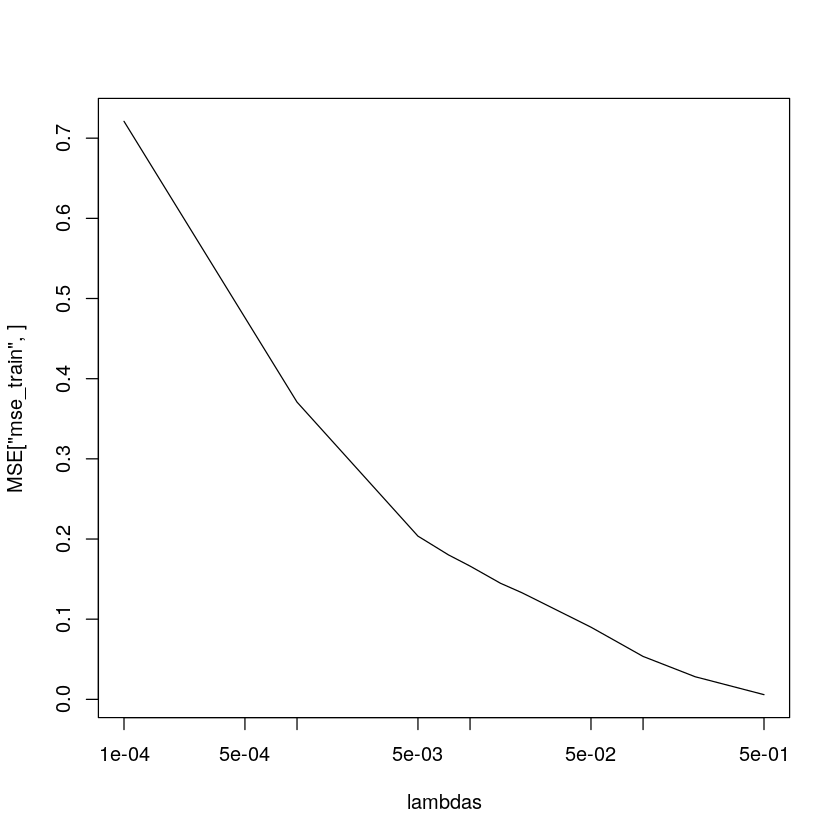

In [23]:
require(gbm)
set.seed(42)
lambdas = c(0.0001,0.001,0.005, 0.0075, 0.01, 0.015, 0.02, 0.05,0.1,0.2,0.5)
gbmmse <- function(lambda, frml, data, subset=train, ytest=y_test, ytrain = y_train){
    model = gbm(formula=frml, data=data[subset,], shrinkage=lambda, distribution='gaussian', n.trees=1000)
    yhat = predict(model,newdata=data[subset,],n.trees=1000)
    ypred = predict(model,newdata=data[-subset,],n.trees=1000)
    mse_test = mean((ytest-ypred)**2)
    mse_train = mean((ytrain-yhat)**2)
    return(c('mse_train' = mse_train, 'mse_test' = mse_test))
}

y_train = Hitters[train,'Salary'] 
MSE = sapply(lambdas, gbmmse, data=Hitters, frml=Salary~., simplify='array')

plot(lambdas, MSE['mse_train',], log='x', type='l')
lambdas[which.min(MSE['mse_train',])]
best_lambda_boost = lambdas[which.min(MSE['mse_train',])]

#### (d) Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.

Best shtinkage parameter:  0.02 
Boosting MSE:  0.1531128

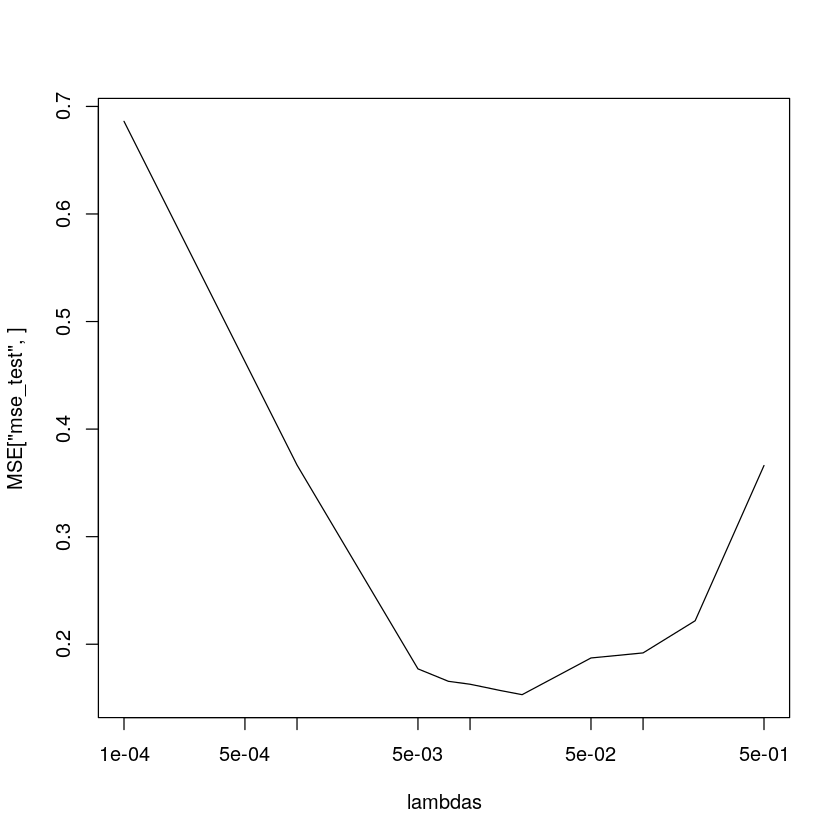

In [24]:
plot(lambdas, MSE['mse_test',], log='x', type='l')
cat('Best shtinkage parameter: ', lambdas[which.min(MSE['mse_test',])],
    '\nBoosting MSE: ', min(MSE['mse_test',]))

#### (e) Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some




Call:
lm(formula = Salary ~ ., data = Hitters[train, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.18848 -0.43658 -0.00423  0.40690  2.73937 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.618e+00  2.030e-01  22.746  < 2e-16 ***
AtBat       -3.957e-03  1.530e-03  -2.586  0.01050 *  
Hits         1.504e-02  5.808e-03   2.590  0.01039 *  
HmRun        1.106e-02  1.490e-02   0.742  0.45902    
Runs        -1.471e-03  6.982e-03  -0.211  0.83334    
RBI         -1.606e-03  6.263e-03  -0.256  0.79792    
Walks        1.285e-02  4.242e-03   3.029  0.00282 ** 
Years        7.256e-02  2.823e-02   2.571  0.01096 *  
CAtBat       5.677e-05  3.156e-04   0.180  0.85744    
CHits       -4.231e-04  1.600e-03  -0.264  0.79174    
CHmRun      -4.421e-04  3.890e-03  -0.114  0.90965    
CRuns        2.023e-03  1.795e-03   1.127  0.26121    
CRBI         2.539e-04  1.648e-03   0.154  0.87774    
CWalks      -1.857e-03  8.255e-04  -2.250  0.02569 *  

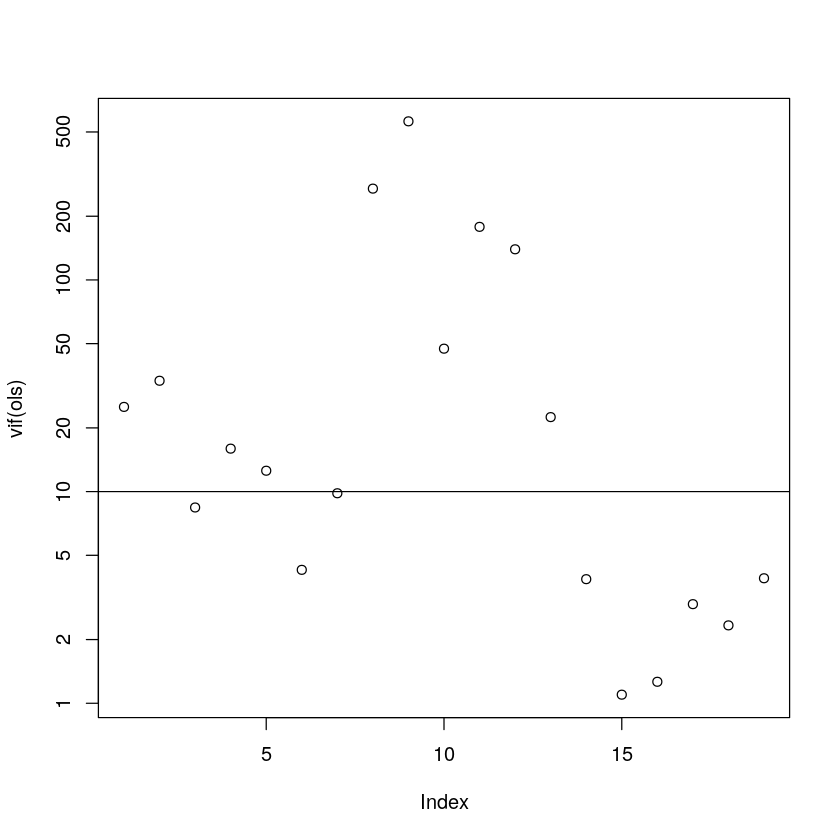

In [25]:
require(car)

ols = lm(Salary~., data=Hitters[train,])
summary(ols)
plot(vif(ols), log='y')
abline(h=10)

In [26]:
cat('Fitted MSE: ', mean(ols$residuals**2))
y_pred = predict(ols, newdata=Hitters[-train,], type='response')
cat('\nTest MSE:   ', mean((y_test-y_pred)**2))

Fitted MSE:  0.3644979
Test MSE:    0.3214257

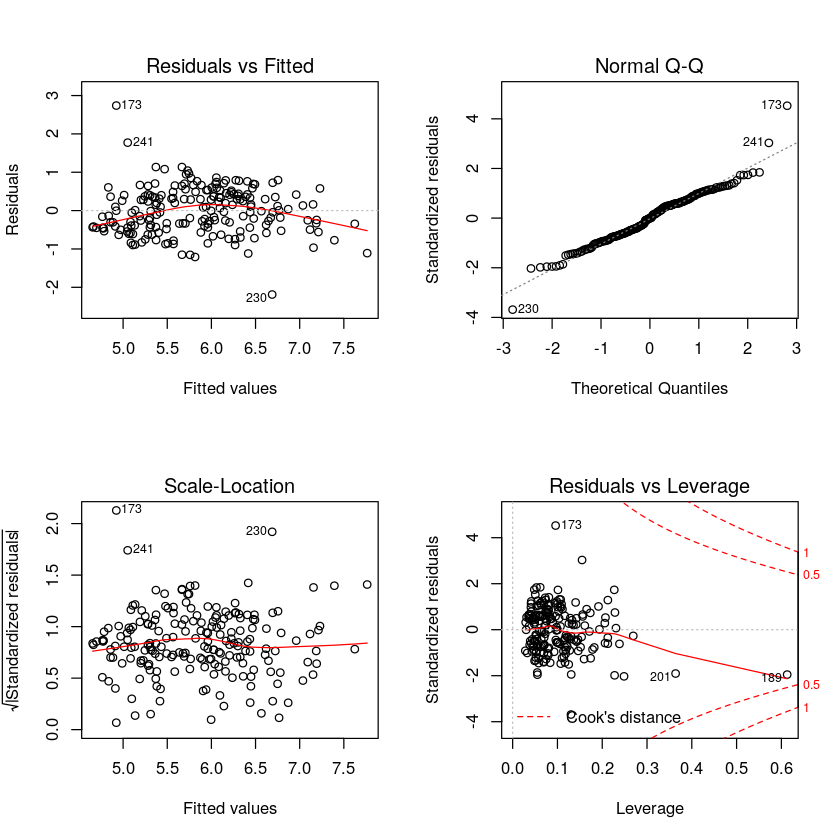

In [27]:
par(mfrow=c(2,2))
plot(ols)

Loading required package: glmnet
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 3.0-2



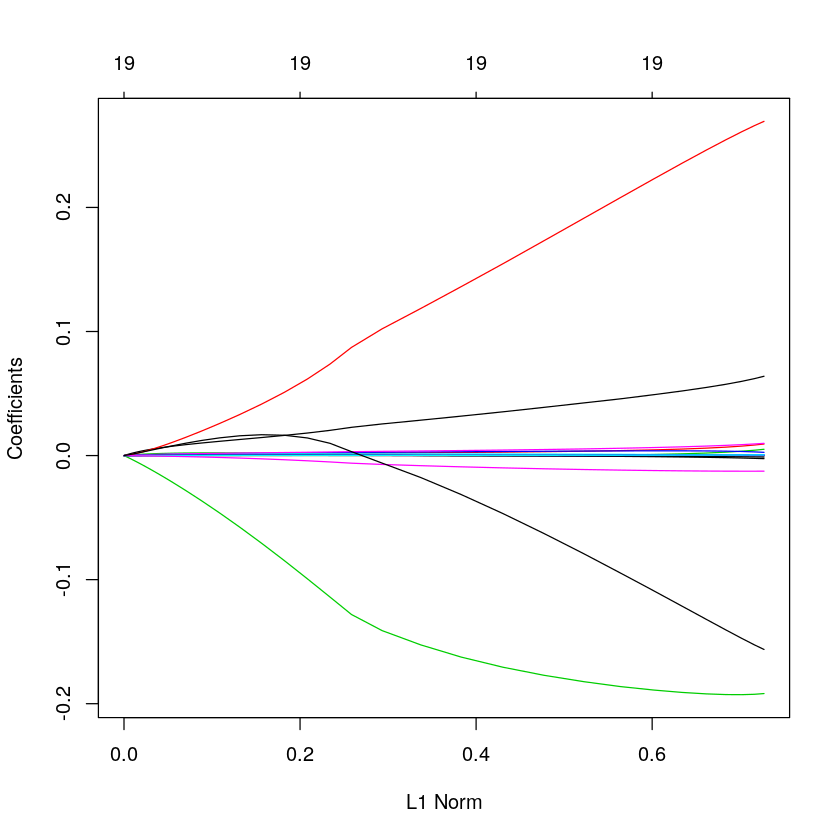

In [28]:
require(glmnet)
X = model.matrix(Salary~., Hitters)[,-1]
y = Hitters$Salary

lambdas =10^seq(10, -2, length = 100)
salary.ridge = glmnet(X[train,], y[train], alpha=0, lambda=lambdas)
plot(salary.ridge)

Ridge Regression MSE:  0.2970711

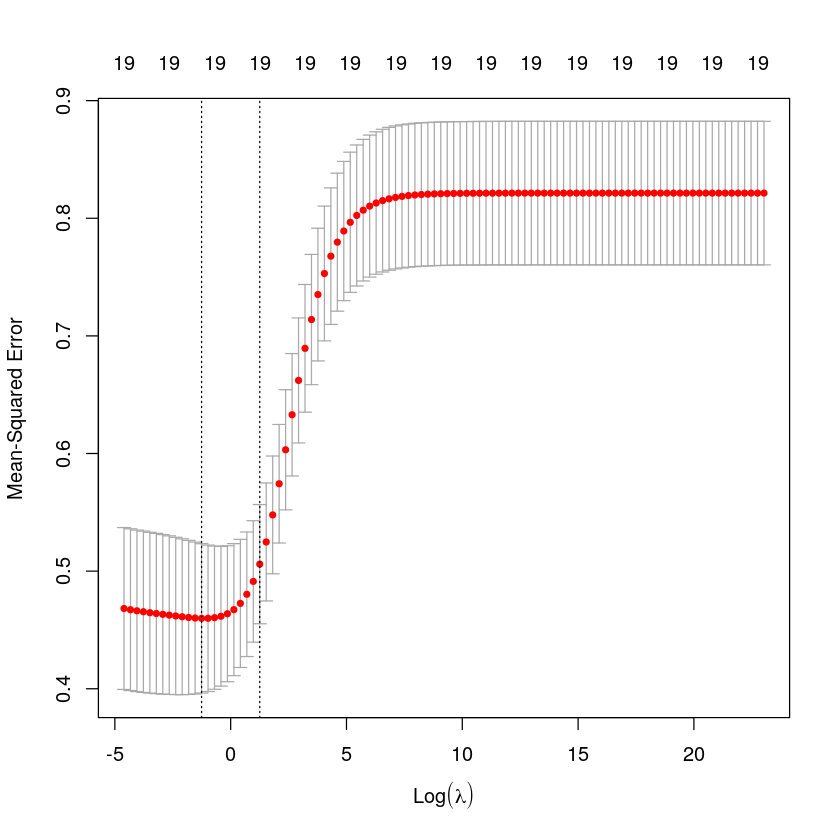

In [29]:
set.seed(55)
salary.ridge.cv = cv.glmnet(X[train,], y[train], alpha=0, lambda=lambdas)
plot(salary.ridge.cv)
y_pred = predict( salary.ridge, s = salary.ridge.cv$lambda.min, newx = X[-train,])
cat('Ridge Regression MSE: ', mean((y_pred-y_test)^2))

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

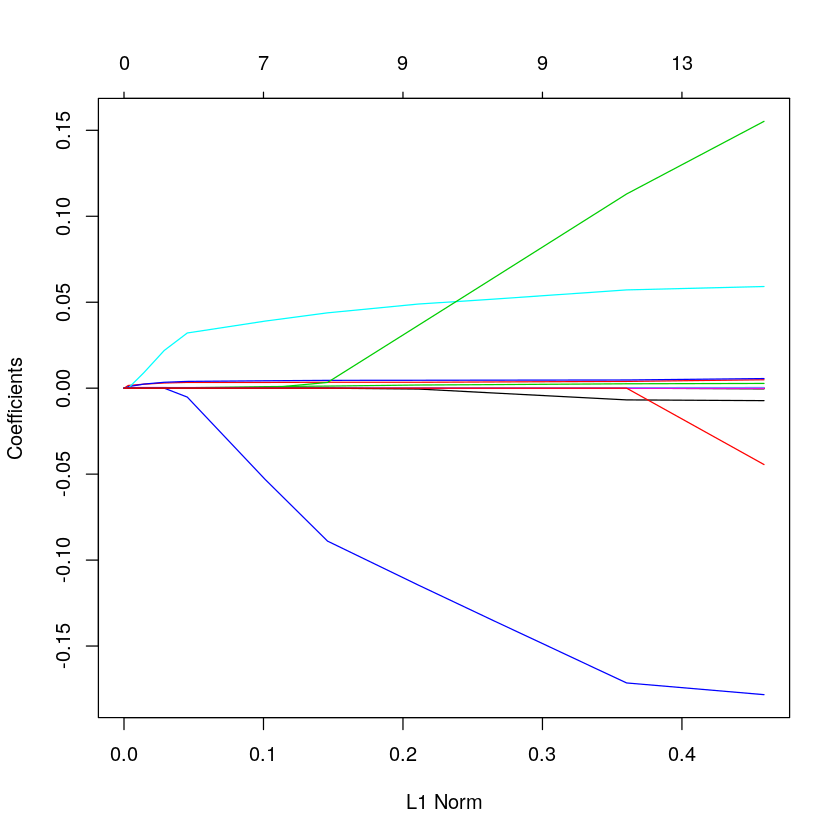

Lasso Regression MSE:  0.3057102

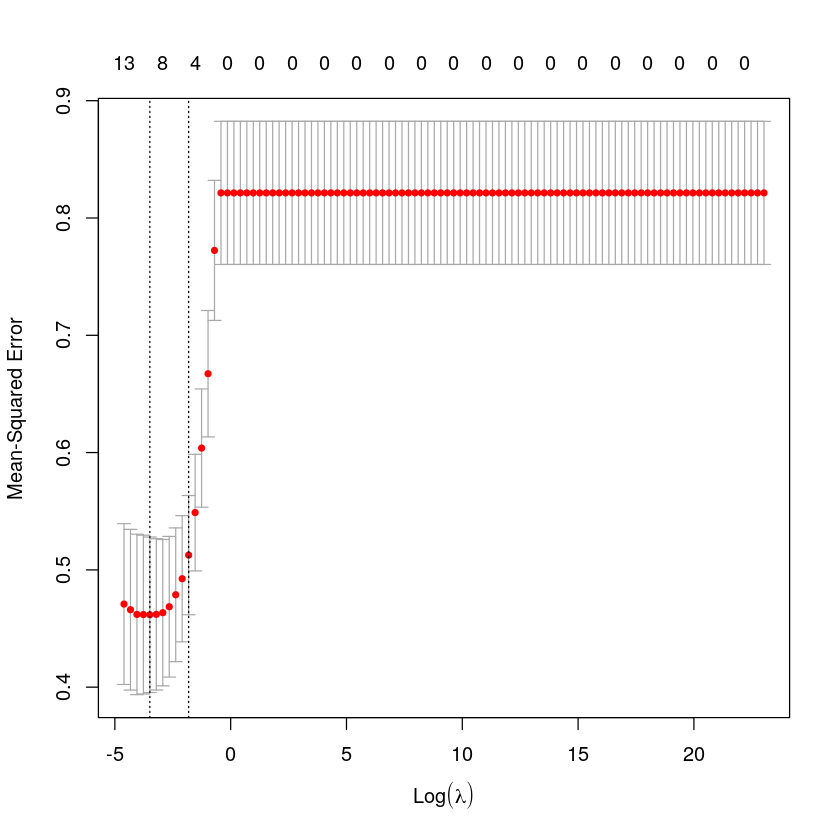

In [30]:
salary.lasso = glmnet(X[train,], y[train], alpha=1, lambda=lambdas)
plot(salary.lasso)
set.seed(55)
salary.lasso.cv = cv.glmnet(X[train,], y[train], alpha=1, lambda=lambdas)
plot(salary.lasso.cv)
y_pred = predict(salary.lasso, s = salary.lasso.cv$lambda.min, newx = X[-train,])
cat('Lasso Regression MSE: ', mean((y_pred-y_test)^2))

In [31]:
# L1 ratio
glmnetmse <- function(ratio){
    salary.glmnet = glmnet(X[train,], y[train], alpha=ratio, lambda=lambdas)
    set.seed(55)
    salary.glmnet.cv = cv.glmnet(X[train,], y[train], alpha=ratio, lambda=lambdas)
    ypred = predict(salary.lasso, s = salary.lasso.cv$lambda.min, newx = X[-train,])
    return(mean((ypred-y_test)^2))
    }

ratios = seq(0,1,0.01)

MSE = sapply(ratios, glmnetmse)
best_ratio = ratios[which.min(MSE)]
salary.glmnet = glmnet(X[train,], y[train], alpha=best_ratio, lambda=lambdas)
set.seed(55)
salary.glmnet.cv = cv.glmnet(X[train,], y[train], alpha=best_ratio, lambda=lambdas)
best_lambda = salary.lasso.cv$lambda.min
cat('Best ratio: ', best_ratio,
    '\nBest penalty: ', best_lambda,
    '\nBest MSE: ', min(MSE))

Best ratio:  0 
Best penalty:  0.03053856 
Best MSE:  0.3057102

In [32]:
# Boosting is still best MSE

### (f) Which variables appear to be the most important predictors in the boosted model?

,var,rel.inf
,<fct>,<dbl>
CAtBat,CAtBat,15.2491521
PutOuts,PutOuts,9.6248204
CRBI,CRBI,7.7781402
Runs,Runs,7.6962712
CHmRun,CHmRun,7.2031084
Walks,Walks,6.8409250
AtBat,AtBat,6.8111852
CHits,CHits,6.7733189
HmRun,HmRun,5.1254147


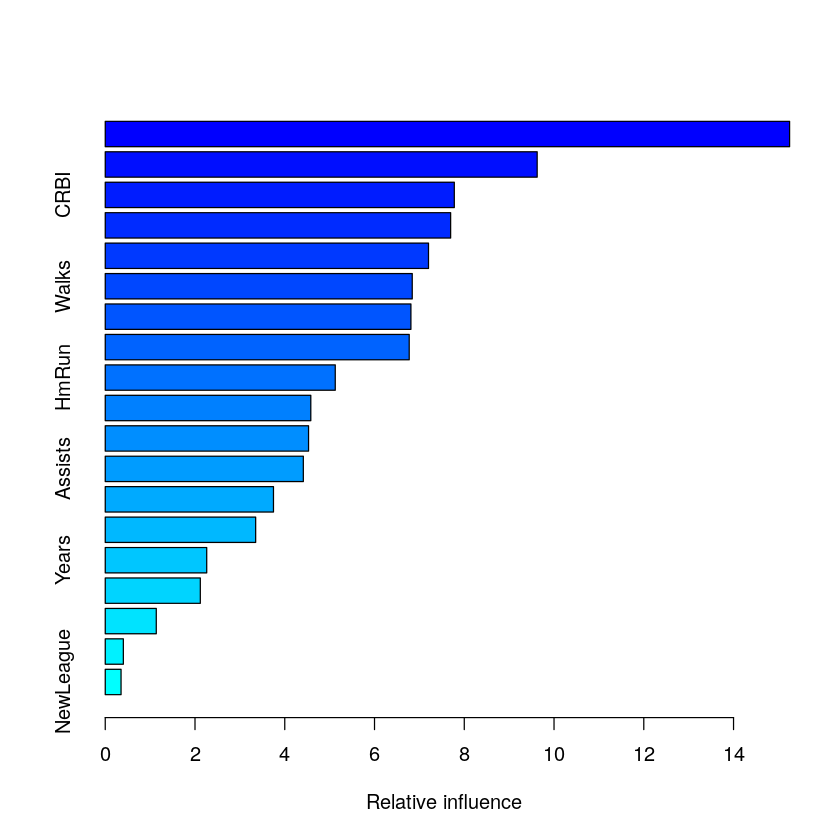

In [33]:
summary(gbm(Salary~., data=Hitters[train,], 
            shrinkage=best_lambda_boost, 
            distribution='gaussian', n.trees=1000))

### (g) Now apply bagging to the training set. What is the test set MSE for this approach?

In [34]:
set.seed(42)
salary.bag=randomForest(Salary~.,data=Hitters,subset=train,mtry=ncol(Hitters)-1,importance=TRUE)
y_pred = predict(salary.bag,newdata=Hitters[-train,])
cat('Bagging MSE: ', mean((y_pred-y_test)^2))

Bagging MSE:  0.1697441

### 11. This question uses the `Caravan` data set.

#### (a) Create a training set consisting of the first 1,000 observations, and a test set consisting of the remaining observations.

#### (b) Fit a boosting model to the training set with `Purchase` as the response and the other variables as predictors. Use 1,000 trees, and a shrinkage value of 0.01. Which predictors appear to be the most important?

#### (c) Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than 20 %. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 50: PVRAAUT has no variation.”Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 71: AVRAAUT has no variation.”

,var,rel.inf
,<fct>,<dbl>
PPERSAUT,PPERSAUT,15.2430406
MKOOPKLA,MKOOPKLA,10.2204975
MOPLHOOG,MOPLHOOG,7.5847339
MBERMIDD,MBERMIDD,5.9836504
PBRAND,PBRAND,4.5574912
ABRAND,ABRAND,4.0760174
MINK3045,MINK3045,4.0314914
MGODGE,MGODGE,3.5061860
MOSTYPE,MOSTYPE,2.8233265


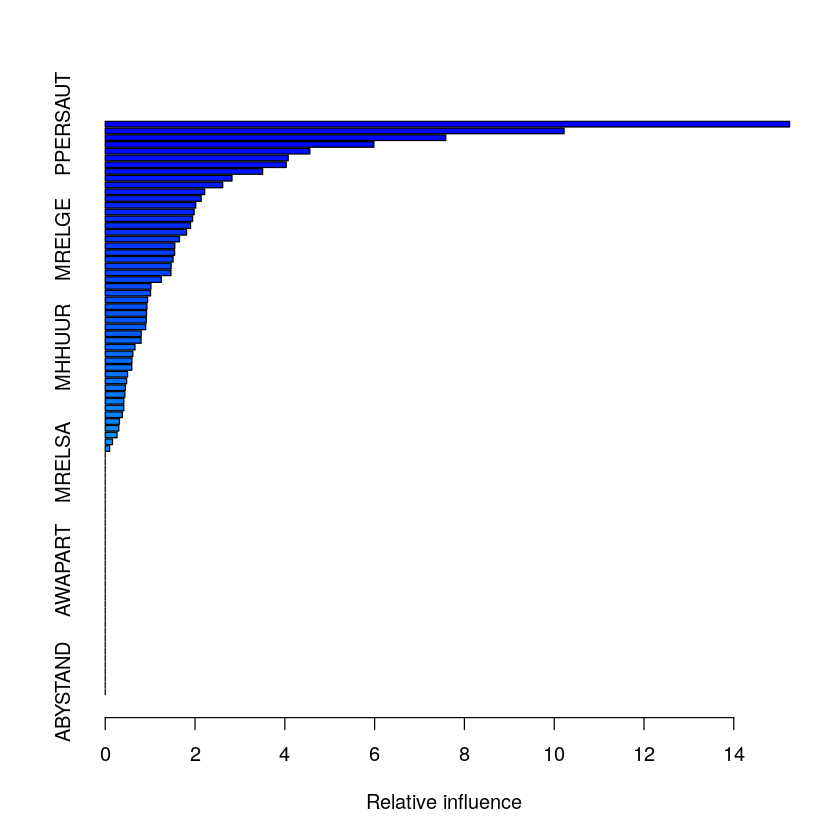

In [35]:
require(gbm)
#a
train = 1:1000
#b
Caravan <- ISLR::Caravan  %>% 
  mutate(Purchase = Purchase == 'Yes')
set.seed(42)
caravan.boost <- gbm(Purchase~., data = Caravan[train,], 
                     n.trees=1000, shrinkage=0.01, 
                     distribution = 'bernoulli')
summary(caravan.boost)

In [36]:
# c-Boost
set.seed(42)
y_pred = predict(caravan.boost, newdata=Caravan[-train,], n.trees=1000, type='response') > 0.2
y_test = Caravan[-train,'Purchase']
class_table = table(y_test, y_pred)
class_table
cat('Accuracy: ', mean(y_test==y_pred))
cat('\nFalse positive: ', class_table['TRUE','FALSE']/sum(class_table['TRUE',]))
cat('\nTrue positive: ', class_table['TRUE','TRUE']/sum(class_table['TRUE',]))

       y_pred
y_test  FALSE TRUE
  FALSE  4415  118
  TRUE    257   32

Accuracy:  0.9222314
False positive:  0.8892734
True positive:  0.1107266

In [37]:
# c-KNN
require(class)
X_train <- Caravan[train,] %>% select(-Purchase)
X_test <- Caravan[-train,] %>% select(-Purchase)
y_train <- Caravan$Purchase[train]
knn1 = knn(X_train, X_test, y_train , k=1)
class_table = table(y_test, knn1)
class_table
cat('Accuracy: ', mean(y_test==knn1))
cat('\nFalse positive: ', class_table['TRUE','FALSE']/sum(class_table['TRUE',]))
cat('\nTrue positive: ', class_table['TRUE','TRUE']/sum(class_table['TRUE',]))

Loading required package: class


       knn1
y_test  FALSE TRUE
  FALSE  4259  274
  TRUE    263   26

Accuracy:  0.8886354
False positive:  0.9100346
True positive:  0.0899654

In [38]:
knn_stats <- function(k){
    ypred = knn(X_train, X_test, y_train , k=k)
    class_table = table(y_test, ypred)
    return(c('Accuracy'= mean(y_test==ypred),
      'False.positive'= class_table['TRUE','FALSE']/sum(class_table['TRUE',]),
      'True.positive'= class_table['TRUE','TRUE']/sum(class_table['TRUE',])))
}
set.seed(34)
knn_results = t(sapply(seq(1,15,2), knn_stats, simplify='array'))
knn_results

Accuracy,False.positive,True.positive
0.8884280,0.9169550,0.083044983
0.9280382,0.9688581,0.031141869
0.9344670,0.9861592,0.013840830
0.9371630,0.9930796,0.006920415
0.9390294,0.9930796,0.006920415
0.9398590,1.0000000,0.000000000
0.9400664,1.0000000,0.000000000
0.9400664,1.0000000,0.000000000


In [39]:
# c-logistic
full.logit = glm(Purchase~., 'binomial', Caravan, subset=train)
options(warn=-1)
reduced.logit = step(full.logit, trace=0)
options(warn=0)
summary(reduced.logit)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = Purchase ~ MGEMOMV + MGODRK + MGODOV + MRELGE + 
    MRELSA + MRELOV + MFALLEEN + MFGEKIND + MBERBOER + MSKD + 
    MKOOPKLA + PPERSAUT + PBESAUT + PGEZONG + PWAOREG + PPLEZIER + 
    APERSAUT + ATRACTOR + AGEZONG + ABRAND, family = "binomial", 
    data = Caravan, subset = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5741  -0.3469  -0.2264  -0.1269   3.3201  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -6.90079    3.22216  -2.142  0.03222 *  
MGEMOMV       -0.64363    0.32632  -1.972  0.04857 *  
MGODRK        -0.34545    0.17068  -2.024  0.04298 *  
MGODOV        -0.26261    0.16214  -1.620  0.10531    
MRELGE         0.59630    0.33789   1.765  0.07760 .  
MRELSA         0.52666    0.31489   1.673  0.09442 .  
MRELOV         0.57137    0.33336   1.714  0.08653 .  
MFALLEEN      -0.23895    0.15132  -1.579  0.11432    
MFGEKIND      -0.24588    0.11934  -2.060  0.03938 *  
MBERBOER      -0.5

In [40]:
y_probs = predict(reduced.logit, newdata=Caravan[-train,], type='response')

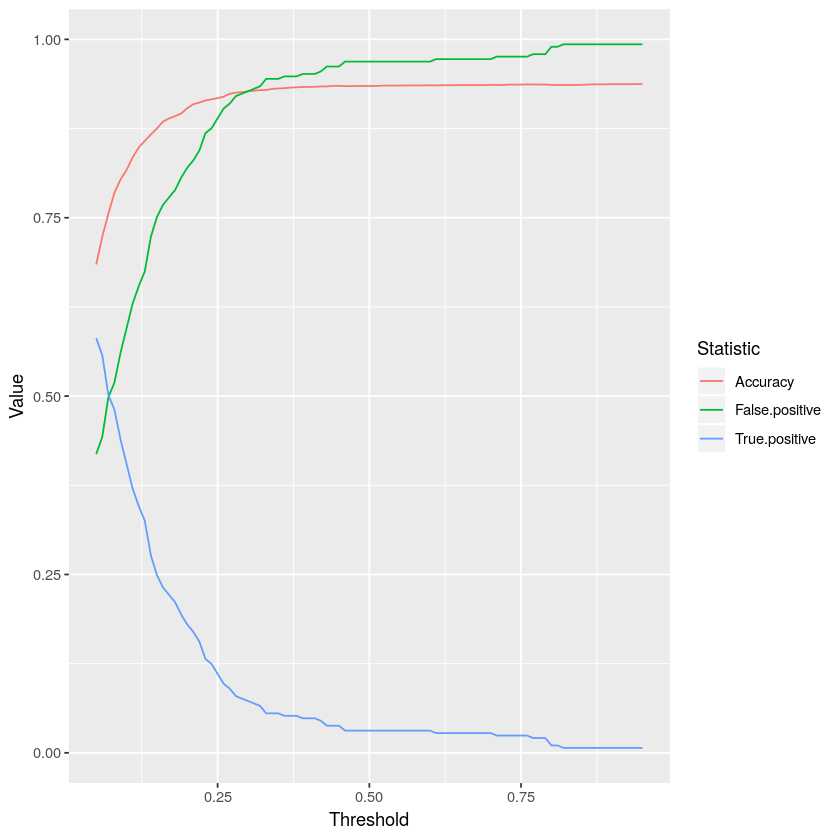

In [41]:
logit_stats <- function(p){
    ypred <- y_probs >= p
    class_table = table(y_test, ypred)
    return(c('Threshold'=p,
             'Accuracy'= mean(y_test==ypred),
             'False.positive'= class_table['TRUE','FALSE']/sum(class_table['TRUE',]),
             'True.positive'= class_table['TRUE','TRUE']/sum(class_table['TRUE',])))
}
set.seed(34)
probs = seq(0.05,0.95,0.01)
logit_results = t(sapply(probs, logit_stats, simplify='array'))
logit_plot <- data.frame(logit_results) %>% 
    gather(Accuracy:True.positive, key = 'Statistic', value = 'Value') %>% 
    ggplot(aes(Threshold,Value,col=Statistic))+
    geom_line()
logit_plot